In [1]:
import pandas as pd
import requests
import os

pd.set_option('display.max_colwidth', None)

## Цель работы

Исследование влияния солнечного ветра (через параметры, такие как интенсивность северного сияния) на скорость земных ветров.

Возьмём основную часть из предыдущей работы и увеличим количество изучаемых параметров.

## С чем предстоит работать

Будем получать данные о погоде через API (возможно дополнительно найдём датасет), и загрузим готовый датасет по северным сияниям. Если получится, загрузим датасет по солнечному ветру.

#### Получим данные через API

В процессе изучения данного источника API были выбраны следующие параметры для загрузки и последующего анализа:  

- Средняя температура воздуха на высоте 2 м: temperature_2m_mean
- Средняя температура по ощущению: apparent_temperature_mean
- Средняя относительная влажность на высоте 2 м: relative_humidity_2m_mean
- Среднее атмосферное давление на уровне моря: pressure_msl_mean
- Суммарное количество осадков: precipitation_sum
- Суммарное количество снегопадов: snowfall_sum
- Средняя облачность: cloudcover_mean
- Средняя точка росы на высоте 2 м: dewpoint_2m_mean
- Средняя видимость: visibility_mean
- Средняя скорость порывов ветра на высоте 10 м: wind_gusts_10m_mean
- Средняя скорость ветра на высоте 10 м: wind_speed_10m_mean
- Преобладающее направление ветра на высоте 10 м: wind_direction_10m_dominant
- Суммарное испарение (ET₀): evapotranspiration_sum
- Суммарное количество солнечных часов: sunshine_duration_sum
- Средний индекс УФ-излучения: uv_index_mean

Все параметры запросить одним запросом не получится, слишком длинный URL. Через POST запрос тоже не вариант, т.к. нужно запрашивать не на точку, а на область, что вернёт большое количество данных. Поэтому разобьём один большой GET запрос на несколько маленьких.

In [2]:
groups = [
    # Группа 1: температура, влажность, давление
    [
    "temperature_2m_max", "temperature_2m_min", "temperature_2m_mean",
    "relative_humidity_2m_mean",
    "pressure_msl_min", "pressure_msl_max", "pressure_msl_mean"
    ],
    
    # Группа 2: осадки, облачность, видимость
    [
    "precipitation_sum", "rain_sum", "snowfall_sum", "precipitation_hours",
    "cloudcover_mean", "visibility_mean"
    ],

    # Группа 3: ветер
    [
        "wind_speed_10m_mean", "wind_speed_10m_max",
        "wind_gusts_10m_mean", "wind_gusts_10m_max",
        "wind_direction_10m_dominant"
    ],

    # Группа 4: тепловое излучение и испарение
    [
        "shortwave_radiation_sum", "et0_fao_evapotranspiration"
    ],

    # Группа 5: температура по ощущениям и УФ
    [
    "apparent_temperature_max", "apparent_temperature_min", "apparent_temperature_mean",
    "uv_index_max"
    ],

    # Группа 6: код погоды
    ["weathercode"]
]


Функция для загрузки данных:

In [3]:
def fetch_weather_data(params, latitude, longitude, start_date, end_date):
    base_url = "https://archive-api.open-meteo.com/v1/archive"
    params_str = ",".join(params)
    
    url = (
        f"{base_url}?latitude={latitude}&longitude={longitude}"
        f"&start_date={start_date}&end_date={end_date}"
        f"&daily={params_str}&timezone=Europe/Berlin"
    )
    
    response = requests.get(url)
    
    if response.status_code == 200:
        data = response.json()
        df = pd.DataFrame(data["daily"])
        df["date"] = pd.to_datetime(df["time"])
        df = df.drop(columns=["time"])
        return df
    else:
        print(f"Ошибка: {response.status_code}")
        print("Ответ:", response.text)
        return None


Загружаем и объединяем всё

In [4]:
# Настройки
latitude = 68.36
longitude = 18.82
start_date = "2020-01-01"
end_date = "2024-12-31"

# Сбор данных из всех групп
dfs = []

for i, group in enumerate(groups):
    df = fetch_weather_data(group, latitude, longitude, start_date, end_date)
    if df is not None:
        dfs.append(df)
    else:
        print(f"Пропущена группа {i + 1} из-за ошибки")

# Объединение всех df по дате
from functools import reduce

df_full_weather = reduce(lambda left, right: pd.merge(left, right, on="date", how="outer"), dfs)

df_full_weather.head()


,temperature_2m_max,temperature_2m_min,temperature_2m_mean,relative_humidity_2m_mean,pressure_msl_min,pressure_msl_max,pressure_msl_mean,date,precipitation_sum,rain_sum,...,wind_gusts_10m_mean,wind_gusts_10m_max,wind_direction_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,uv_index_max,weathercode
0,1.1,-6.4,-4.6,87,976.1,999.3,989.2,2020-01-01,12.6,0.1,...,34.1,65.2,83,0.0,0.02,-3.0,-11.1,-8.7,None,75
1,3.3,-0.4,1.8,87,969.6,983.9,976.7,2020-01-02,23.0,5.1,...,53.3,87.1,282,0.0,0.08,0.9,-4.4,-2.0,None,75
2,3.0,-4.7,-0.6,80,964.2,969.3,966.4,2020-01-03,6.1,2.2,...,41.0,61.6,256,0.0,0.12,-0.8,-8.7,-4.4,None,73
3,-3.4,-6.1,-5.1,78,964.7,1005.3,984.4,2020-01-04,2.8,0.0,...,53.0,74.9,296,0.0,0.20,-8.9,-12.0,-10.5,None,73
4,-5.2,-10.0,-6.8,82,998.1,1009.5,1005.1,2020-01-05,1.8,0.1,...,37.5,54.4,274,0.0,0.07,-9.4,-14.7,-11.6,None,73


In [5]:
# Координаты интересующего местоположения (Берлин)
latitude = 68.36
longitude = 18.82

# Даты начала и окончания периода
start_date = '2020-01-01'
end_date = '2025-04-06'

url = f"https://archive-api.open-meteo.com/v1/archive?latitude={latitude}&longitude={longitude}&start_date={start_date}&end_date={end_date}&daily=wind_speed_10m_max&timezone=Europe/Berlin"
response = requests.get(url)

if response.status_code == 200:
    data = response.json()
    df_wind = pd.DataFrame(data['daily'])
    print(df_wind.columns)
    df_wind['date'] = pd.to_datetime(df_wind['time'])
    df_wind = df_wind[['date', 'wind_speed_10m_max']]
    df_wind.rename(columns={'wind_speed_10m_max': 'max_wind_speed_10m'}, inplace=True)
else:
    print(f"Ошибка при получении данных: {response.status_code}")

Index(['time', 'wind_speed_10m_max'], dtype='object')


In [6]:
df_wind.head()

,date,max_wind_speed_10m
0,2020-01-01,12.0
1,2020-01-02,25.7
2,2020-01-03,16.8
3,2020-01-04,24.1
4,2020-01-05,16.0


Посмотрим структуру и пропуски итоговой таблицы

In [7]:
print(df_full_weather.info())

# Подсчёт пропущенных значений
missing_counts = df_full_weather.isnull().sum()
missing_percent = (df_full_weather.isnull().mean() * 100).round(2)

print("\n Пропущенные значения:")
pd.DataFrame({
    "Пропущено": missing_counts,
    "Процент (%)": missing_percent
}).sort_values("Процент (%)", ascending=False)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1827 entries, 0 to 1826
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   temperature_2m_max           1827 non-null   float64       
 1   temperature_2m_min           1827 non-null   float64       
 2   temperature_2m_mean          1827 non-null   float64       
 3   relative_humidity_2m_mean    1827 non-null   int64         
 4   pressure_msl_min             1827 non-null   float64       
 5   pressure_msl_max             1827 non-null   float64       
 6   pressure_msl_mean            1827 non-null   float64       
 7   date                         1827 non-null   datetime64[ns]
 8   precipitation_sum            1827 non-null   float64       
 9   rain_sum                     1827 non-null   float64       
 10  snowfall_sum                 1827 non-null   float64       
 11  precipitation_hours          1827 non-null 

,Пропущено,Процент (%)
visibility_mean,1827,100.0
uv_index_max,1827,100.0
temperature_2m_min,0,0.0
apparent_temperature_mean,0,0.0
apparent_temperature_min,0,0.0
apparent_temperature_max,0,0.0
et0_fao_evapotranspiration,0,0.0
shortwave_radiation_sum,0,0.0
wind_direction_10m_dominant,0,0.0
wind_gusts_10m_max,0,0.0


Удалим пустые столбцы

In [8]:
df_full_weather = df_full_weather.drop(columns=["visibility_mean", "uv_index_max"])

In [9]:
print(f"Финальная форма таблицы: {df_full_weather.shape[0]} строк, {df_full_weather.shape[1]} столбцов")
print("\nСписок оставшихся признаков:")
print(df_full_weather.columns.tolist())

Финальная форма таблицы: 1827 строк, 24 столбцов

Список оставшихся признаков:
['temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean', 'relative_humidity_2m_mean', 'pressure_msl_min', 'pressure_msl_max', 'pressure_msl_mean', 'date', 'precipitation_sum', 'rain_sum', 'snowfall_sum', 'precipitation_hours', 'cloudcover_mean', 'wind_speed_10m_mean', 'wind_speed_10m_max', 'wind_gusts_10m_mean', 'wind_gusts_10m_max', 'wind_direction_10m_dominant', 'shortwave_radiation_sum', 'et0_fao_evapotranspiration', 'apparent_temperature_max', 'apparent_temperature_min', 'apparent_temperature_mean', 'weathercode']


## Работа с загруженным датасетом

Воспользуемся сайтом https://supermag.jhuapl.edu/, который предоставляет на скачивание готовые датасеты от большого количества различных обсерваторий.  

Возьмём данные для Абиско, Швеция (68.36° N, 18.82° E), т.к. у них самая популярная обсерватория по наблюдению за северными сияниями.

Данные были загружены под годам (2020 - 2025).  

Название файла: "SuperMAG_60s_ABK_2020_rev-0006.1744225539.netcdf".  

Это популярный формат данных для хранения многомерных данных. Для работы с ним нужно установить библиотеку netCDF4.

#### Посмотрим, какие данные у нас есть в скачанных файлах

In [10]:
from netCDF4 import Dataset

file_path = './data/solar_wind_speed/SuperMAG_60s_ABK_2020_rev-0006.1744225539.netcdf'
dataset = Dataset(file_path)

print("Переменные в файле:")
for key in dataset.variables.keys():
    print("-", key)

Переменные в файле:
- dbe_geo
- dbe_nez
- dbn_geo
- dbn_nez
- dbz_geo
- dbz_nez
- decl
- extent
- glat
- glon
- id
- mcolat
- mlt
- npnt
- sza
- time_dy
- time_hr
- time_mo
- time_mt
- time_sc
- time_yr


Данный датасет содержит следующие ключи:

```
dict_keys([
  'dbe_geo', 'dbe_nez',
  'dbn_geo', 'dbn_nez',
  'dbz_geo', 'dbz_nez',
  'decl', 'extent', 'glat', 'glon', 'id', 'mcolat', 'mlt', 'npnt',
  'sza', 'time_dy', 'time_hr', 'time_mo', 'time_mt', 'time_sc', 'time_yr'
])
```

Что это значит?
- dbn / dbe / dbz — компоненты магнитного поля:

    - dbn — северная компонента,

    - dbe — восточная,

    - dbz — вертикальная (вниз).

- _geo — географическая система координат

- _nez — система NEZ (North-East-Vertical)  

In [12]:
import os
from netCDF4 import Dataset
import pandas as pd

folder = "./data/solar_wind_speed"
all_dfs = []

def load_supermag_file(filepath):
    dataset = Dataset(filepath)
    
    time = pd.to_datetime({
        "year": dataset.variables["time_yr"][:].flatten(),
        "month": dataset.variables["time_mo"][:].flatten(),
        "day": dataset.variables["time_dy"][:].flatten(),
        "hour": dataset.variables["time_hr"][:].flatten(),
        "minute": dataset.variables["time_mt"][:].flatten()
    })

    df = pd.DataFrame({"datetime": time})

    skip_vars = {"time_yr", "time_mo", "time_dy", "time_hr", "time_mt"}
    for var in dataset.variables:
        if var not in skip_vars:
            values = dataset.variables[var][:]
            # Преобразуем в 1D при необходимости
            if values.ndim > 1:
                values = values[:, 0]
            df[var] = values

    dataset.close()
    return df

# Перебор всех netcdf файлов за 2020–2024
for year in range(2020, 2025):
    # ищем файл на этот год
    files = [f for f in os.listdir(folder) if f"SuperMAG_60s_ABK_{year}" in f and f.endswith(".netcdf")]
    if files:
        filepath = os.path.join(folder, files[0])
        df_year = load_supermag_file(filepath)
        all_dfs.append(df_year)

# Объединяем по времени
df_supermag_full = pd.concat(all_dfs)
df_supermag_full = df_supermag_full.sort_values("datetime").reset_index(drop=True)

df_supermag_full.head()


,datetime,dbe_geo,dbe_nez,dbn_geo,dbn_nez,dbz_geo,dbz_nez,decl,extent,glat,glon,id,mcolat,mlt,npnt,sza,time_sc
0,2020-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,180.0,60.0,68.349998,18.82,ABK,24.26149,1.555906,1,133.377365,0.0
1,2020-01-01 00:01:00,NaN,NaN,NaN,NaN,NaN,NaN,180.0,60.0,68.349998,18.82,ABK,24.26149,1.572706,1,133.340912,0.0
2,2020-01-01 00:02:00,NaN,NaN,NaN,NaN,NaN,NaN,180.0,60.0,68.349998,18.82,ABK,24.26149,1.589516,1,133.304001,0.0
3,2020-01-01 00:03:00,NaN,NaN,NaN,NaN,NaN,NaN,180.0,60.0,68.349998,18.82,ABK,24.26149,1.606335,1,133.266647,0.0
4,2020-01-01 00:04:00,NaN,NaN,NaN,NaN,NaN,NaN,180.0,60.0,68.349998,18.82,ABK,24.26149,1.622884,1,133.228821,0.0


Проверим данные на пропуски

In [13]:
# Кол-во и процент пропусков
missing_counts = df_supermag_full.isnull().sum()
missing_percent = (df_supermag_full.isnull().mean() * 100).round(2)

missing_df = pd.DataFrame({
    "Пропущено": missing_counts,
    "Процент (%)": missing_percent
})

missing_df = missing_df[missing_df["Пропущено"] > 0].sort_values("Процент (%)", ascending=False)

print("Пропуски в данных SuperMAG:")
missing_df


Пропуски в данных SuperMAG:


,Пропущено,Процент (%)
dbe_geo,660474,25.1
dbe_nez,660474,25.1
dbn_geo,660474,25.1
dbn_nez,660474,25.1
dbz_geo,660474,25.1
dbz_nez,660474,25.1


В данных присутствуют пропуски.  

Пропуски в данных SuperMAG, особенно в компонентах магнитного поля, вероятно, обусловлены техническими проблемами с оборудованием или условиями передачи данных.

Нам важны агрегированные показатели, а не точные пики, поэтому их можно заполнить.

## Заполнение пропущенных данных

Построим график для оценки, каким способом нам следует заполнить пропуски. Возьмём параметр dbz - вертикальная составляющая северного сияния.

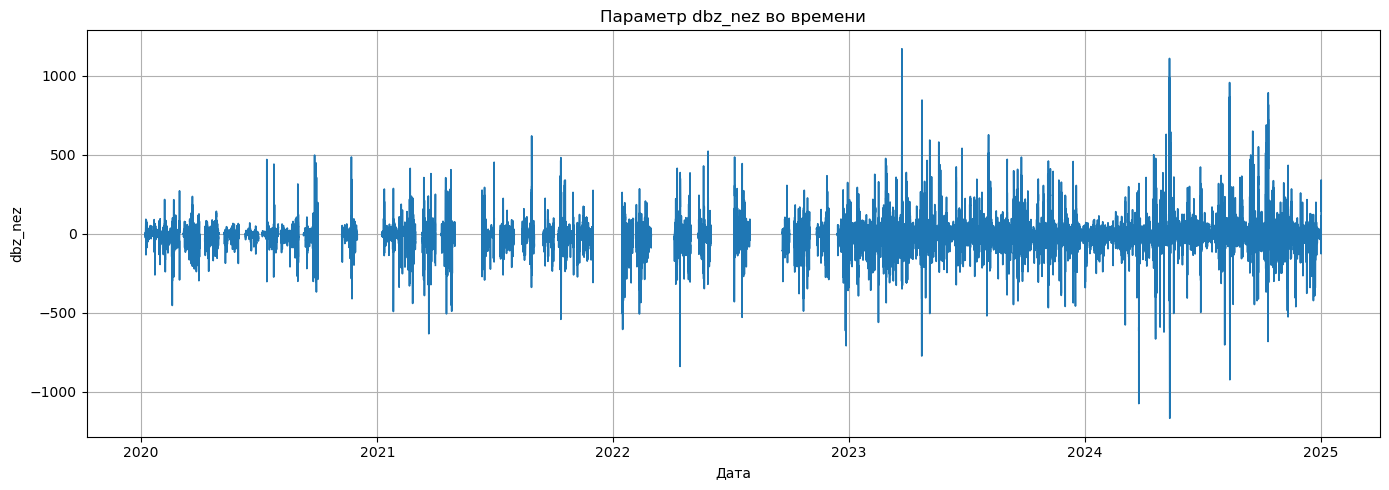

In [14]:
df_supermag_plot = df_supermag_full.copy()

df_supermag_plot["datetime"] = pd.to_datetime(df_supermag_plot["datetime"])

plt.figure(figsize=(14, 5))
plt.plot(df_supermag_plot["datetime"], df_supermag_plot["dbz_nez"], linewidth=1.2)
plt.title("Параметр dbz_nez во времени")
plt.xlabel("Дата")
plt.ylabel("dbz_nez")
plt.grid(True)
plt.tight_layout()
plt.show()


По графику мы можем сделать выводы:
- Данные сильно колеблются — заметны частые и резкие изменения амплитуды.

- Нет чёткой сезонности или регулярности (например, синусоидального тренда).

- Есть всплески (магнитные бури), но они выглядят как единичные "пики".

- Структура выглядит шумной, с высокой дисперсией.

#### Что это говорит о методах заполнения:

|Метод	|Подходит?	|Почему|
|-|-|-|
|Среднее (mean)	| Да	|В условиях шума и хаотичности среднее значение даёт устойчивую, нейтральную оценку, не создаёт трендов и не усиливает всплески.|
|Интерполяция	| Частично	|Если пропусков много подряд — она может создать ложные плавные переходы в данных, где их быть не должно.|
|Соседние значения (ffill/bfill)	| Нет	|Это приведёт к повторам пиков или затуханий, которых нет в природе.|
|Медиана	| Нет	|Не учитывает амплитуду сигнала и сглаживает реальные бури.|
|Модельные методы	| Слишком сложно	|Имеют смысл только при чёткой зависимости от других признаков, а здесь — это шумовой временной ряд.|

#### Заполним пропуски средним значением

In [29]:
df_supermag_filled = df_supermag_full.copy()

# Заполняем пропуски средним по колонке
cols_with_nans = df_supermag_filled.columns[df_supermag_filled.isnull().any()]
df_supermag_filled[cols_with_nans] = df_supermag_filled[cols_with_nans].fillna(
    df_supermag_filled[cols_with_nans].mean()
)

Проверим

In [30]:
total_missing = df_supermag_filled.isnull().sum().sum()
print(f"Осталось пропущенных значений: {total_missing}")

Осталось пропущенных значений: 0


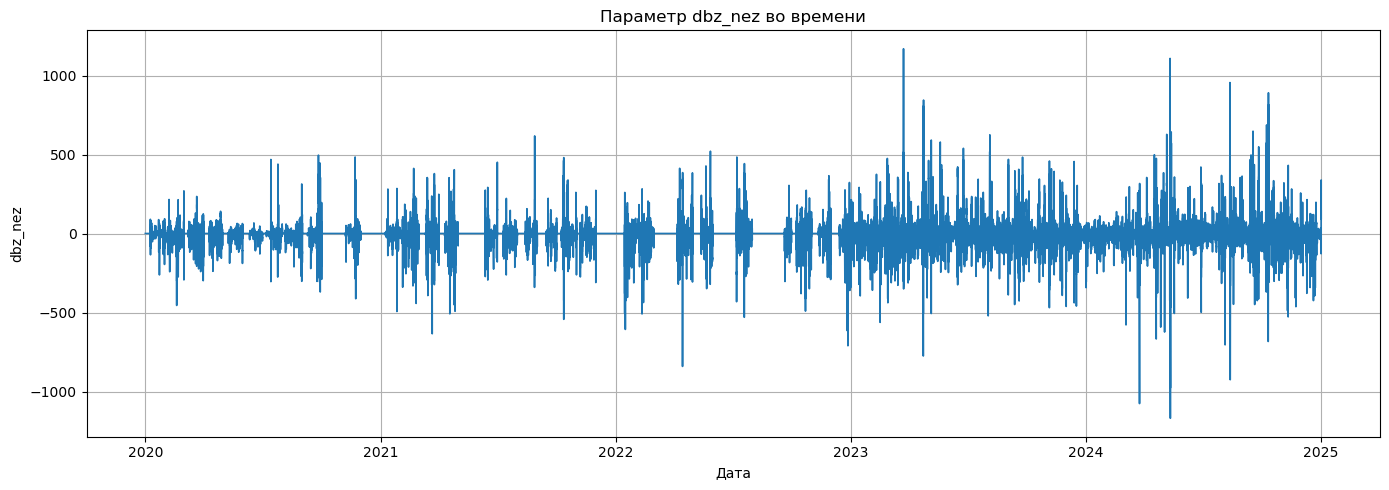

In [31]:
df_supermag_plot = df_supermag_filled.copy()
df_supermag_plot["datetime"] = pd.to_datetime(df_supermag_plot["datetime"])

plt.figure(figsize=(14, 5))
plt.plot(df_supermag_plot["datetime"], df_supermag_plot["dbz_nez"], linewidth=1.2)
plt.title("Параметр dbz_nez во времени")
plt.xlabel("Дата")
plt.ylabel("dbz_nez")
plt.grid(True)
plt.tight_layout()
plt.show()

#### Заполнение интерполяцией (не берём в работу)
Для интереса заполним данные интерполяцией и построим график.

In [18]:
df_supermag_interpol = df_supermag_full.copy()
df_supermag_interpol = df_supermag_interpol.sort_values("datetime")
df_supermag_interpol.set_index("datetime", inplace=True)

# Интерполяция по времени
df_supermag_interpol = df_supermag_interpol.interpolate(method='time')

# Если остались пропуски в начале или конце — заполним ffill/bfill
df_supermag_interpol = df_supermag_interpol.fillna(method='ffill').fillna(method='bfill')
df_supermag_interpol = df_supermag_interpol.reset_index()

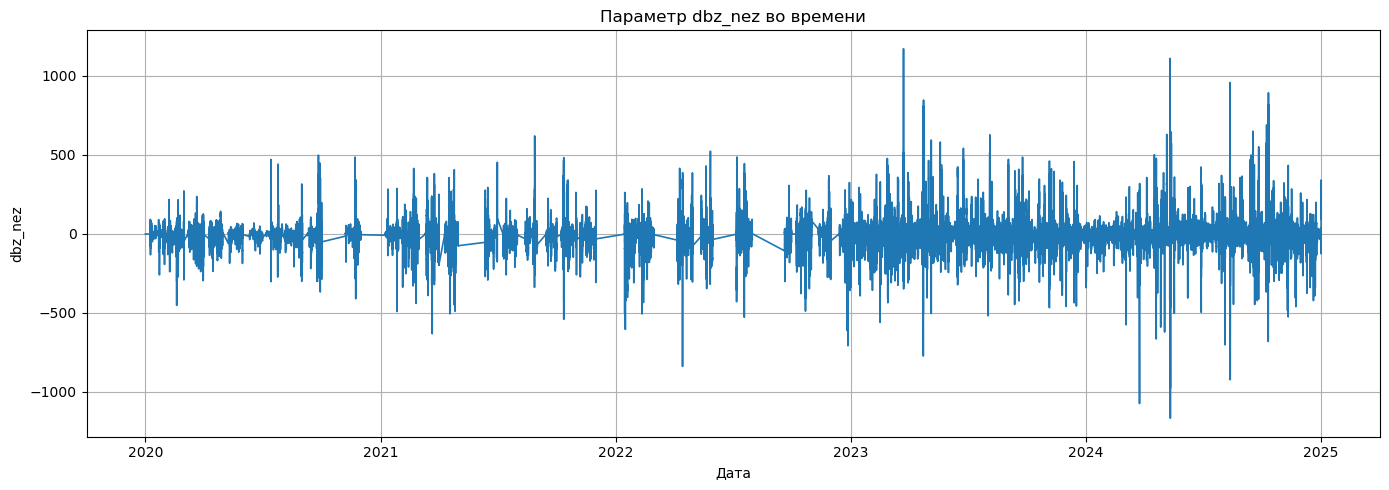

In [19]:
df_supermag_interpol["datetime"] = pd.to_datetime(df_supermag_interpol["datetime"])

plt.figure(figsize=(14, 5))
plt.plot(df_supermag_interpol["datetime"], df_supermag_interpol["dbz_nez"], linewidth=1.2)
plt.title("Параметр dbz_nez во времени")
plt.xlabel("Дата")
plt.ylabel("dbz_nez")
plt.grid(True)
plt.tight_layout()
plt.show()

На графике видим появление неестественных трендов, что может негативно сказаться на результате.

## Объединим таблицы погоды и северных сияний

#### Агрегируем df_supermag_filled по дням

In [20]:
df_supermag_filled["date"] = df_supermag_filled["datetime"].dt.date
df_supermag_daily = df_supermag_filled.groupby("date").mean().reset_index()
df_supermag_daily.head()

C:\Users\lavrv\AppData\Local\Temp\ipykernel_9452\3967330058.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_supermag_daily = df_supermag_filled.groupby("date").mean().reset_index()


,date,dbe_geo,dbe_nez,dbn_geo,dbn_nez,dbz_geo,dbz_nez,decl,extent,glat,glon,mcolat,mlt,npnt,sza,time_sc
0,2020-01-01,5.170509,7.72807,-15.370855,-14.250418,1.27664,1.27664,180.0,60.0,68.349998,18.82,24.261492,12.352295,1.0,112.128395,0.0
1,2020-01-02,5.170509,7.72807,-15.370855,-14.250418,1.27664,1.27664,180.0,60.0,68.349998,18.82,24.261492,12.344188,1.0,112.047852,0.0
2,2020-01-03,5.170509,7.72807,-15.370855,-14.250418,1.27664,1.27664,180.0,60.0,68.349998,18.82,24.261492,12.352819,1.0,111.960030,0.0
3,2020-01-04,5.170509,7.72807,-15.370855,-14.250418,1.27664,1.27664,180.0,60.0,68.349998,18.82,24.261492,12.344861,1.0,111.864944,0.0
4,2020-01-05,5.170509,7.72807,-15.370855,-14.250418,1.27664,1.27664,180.0,60.0,68.349998,18.82,24.261492,12.336991,1.0,111.762672,0.0


#### Объединяем с погодой

In [21]:
df_full_weather["date"] = pd.to_datetime(df_full_weather["date"]).dt.date
df_combined = pd.merge(df_full_weather, df_supermag_daily, on="date", how="inner")

print(f"Объединённый датасет: {df_combined.shape}")
df_combined.head()

Объединённый датасет: (1827, 39)


,temperature_2m_max,temperature_2m_min,temperature_2m_mean,relative_humidity_2m_mean,pressure_msl_min,pressure_msl_max,pressure_msl_mean,date,precipitation_sum,rain_sum,...,dbz_nez,decl,extent,glat,glon,mcolat,mlt,npnt,sza,time_sc
0,1.1,-6.4,-4.6,87,976.1,999.3,989.2,2020-01-01,12.6,0.1,...,1.27664,180.0,60.0,68.349998,18.82,24.261492,12.352295,1.0,112.128395,0.0
1,3.3,-0.4,1.8,87,969.6,983.9,976.7,2020-01-02,23.0,5.1,...,1.27664,180.0,60.0,68.349998,18.82,24.261492,12.344188,1.0,112.047852,0.0
2,3.0,-4.7,-0.6,80,964.2,969.3,966.4,2020-01-03,6.1,2.2,...,1.27664,180.0,60.0,68.349998,18.82,24.261492,12.352819,1.0,111.960030,0.0
3,-3.4,-6.1,-5.1,78,964.7,1005.3,984.4,2020-01-04,2.8,0.0,...,1.27664,180.0,60.0,68.349998,18.82,24.261492,12.344861,1.0,111.864944,0.0
4,-5.2,-10.0,-6.8,82,998.1,1009.5,1005.1,2020-01-05,1.8,0.1,...,1.27664,180.0,60.0,68.349998,18.82,24.261492,12.336991,1.0,111.762672,0.0


## Проведём EDA анализ

#### Создадим "индикатор всплеска" активности

Допустим, мы выберем dbz_nez как прокси-метрику "силы солнечного ветра на Земле" (компонента по вертикали). Добавим бинарный флаг:

In [22]:
# Пороговое значение по dbz_nez (верхние 5% самых "бурных" дней)
threshold = df_combined["dbz_nez"].quantile(0.95)

df_combined["geomagnetic_storm"] = (df_combined["dbz_nez"] >= threshold).astype(int)
print(f"Порог активности (95% квантиль): {threshold}")

Порог активности (95% квантиль): 20.381345939636226


#### Построим корреляционную матрицу

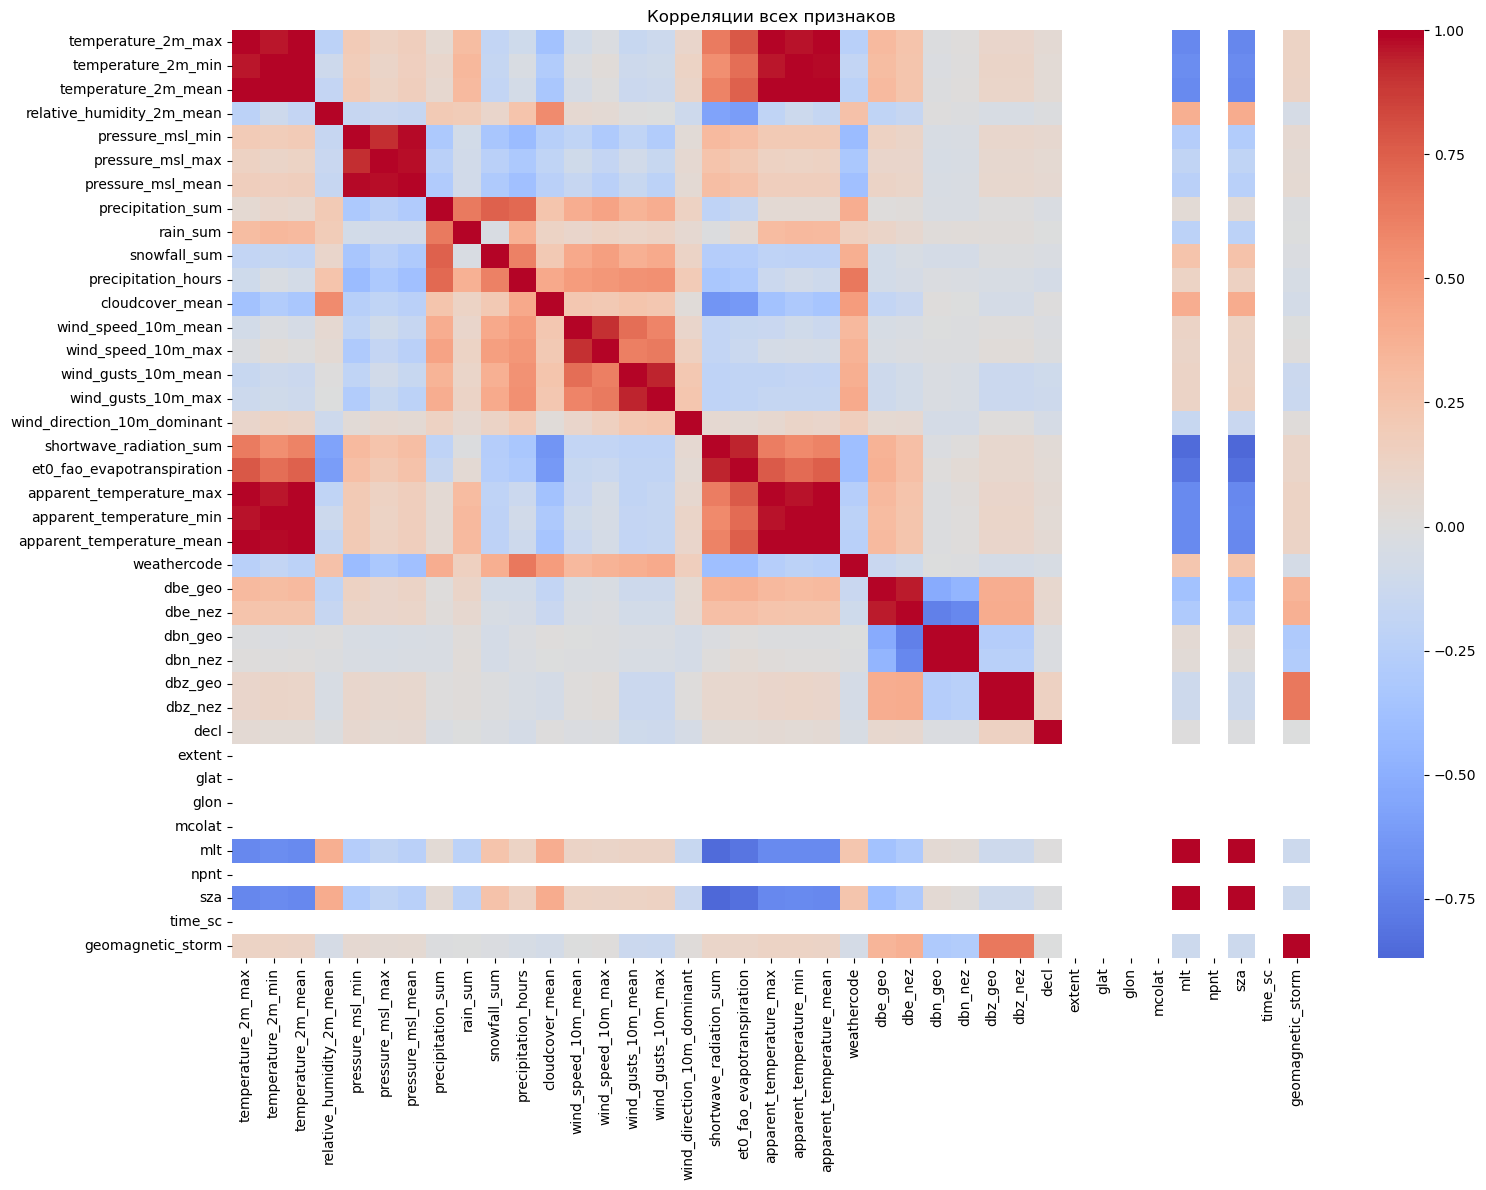

In [23]:
import seaborn as sns

plt.figure(figsize=(16, 12))
sns.heatmap(df_combined.corr(numeric_only=True), cmap='coolwarm', center=0)
plt.title("Корреляции всех признаков")
plt.tight_layout()
plt.show()

#### Сравнение погоды в бурные vs. спокойные дни

In [24]:
cols_to_compare = [
    "wind_speed_10m_mean", "temperature_2m_mean", "precipitation_sum",
    "cloudcover_mean", "pressure_msl_mean"
]

storm_days = df_combined[df_combined["geomagnetic_storm"] == 1]
quiet_days = df_combined[df_combined["geomagnetic_storm"] == 0]

print("Сравнение средних:")
for col in cols_to_compare:
    storm_mean = storm_days[col].mean()
    quiet_mean = quiet_days[col].mean()
    diff = storm_mean - quiet_mean
    print(f"{col}: бурные = {storm_mean:.2f}, спокойные = {quiet_mean:.2f}, Δ = {diff:.2f}")


Сравнение средних:
wind_speed_10m_mean: бурные = 10.02, спокойные = 10.04, Δ = -0.01
temperature_2m_mean: бурные = 6.04, спокойные = 1.30, Δ = 4.74
precipitation_sum: бурные = 2.44, спокойные = 2.72, Δ = -0.28
cloudcover_mean: бурные = 77.61, спокойные = 84.74, Δ = -7.13
pressure_msl_mean: бурные = 1011.91, спокойные = 1008.70, Δ = 3.21


#### Визуализация распределений

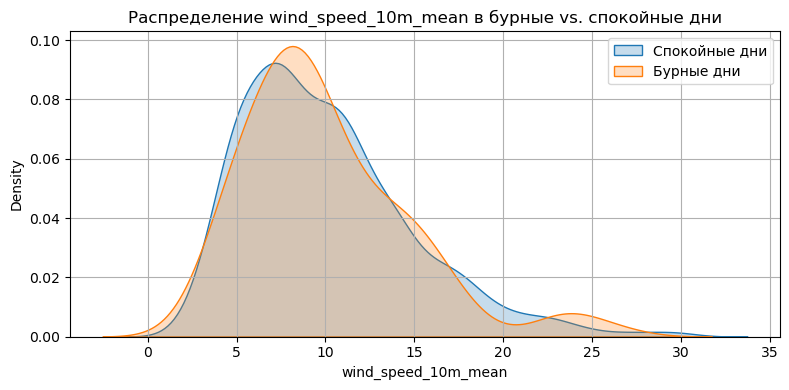

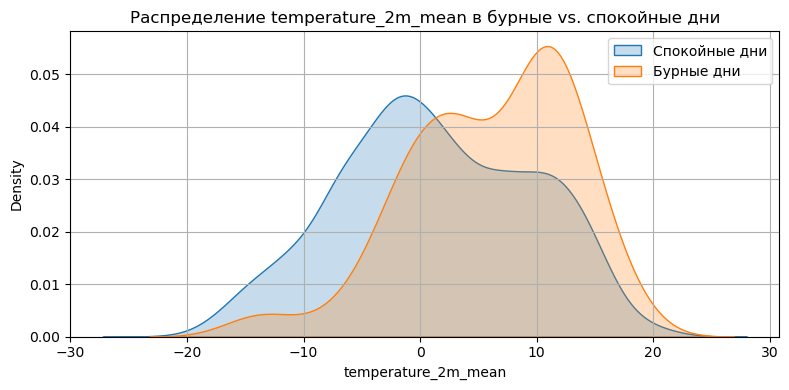

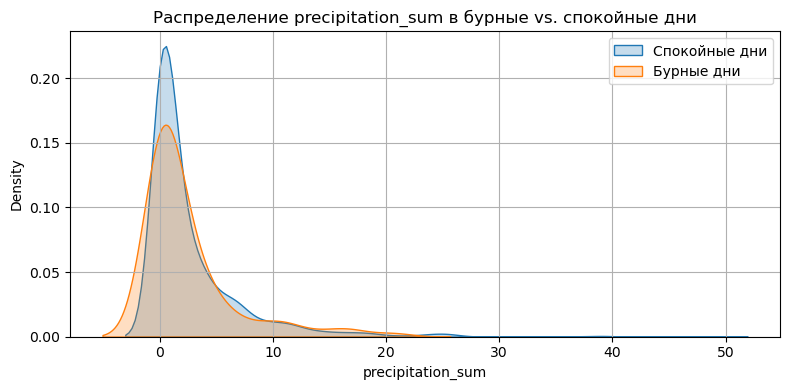

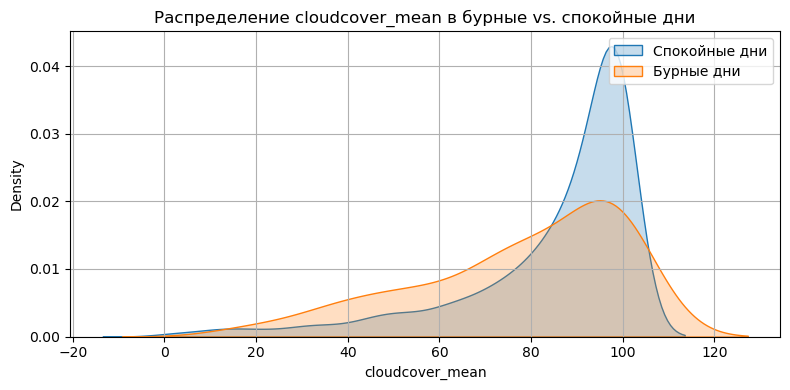

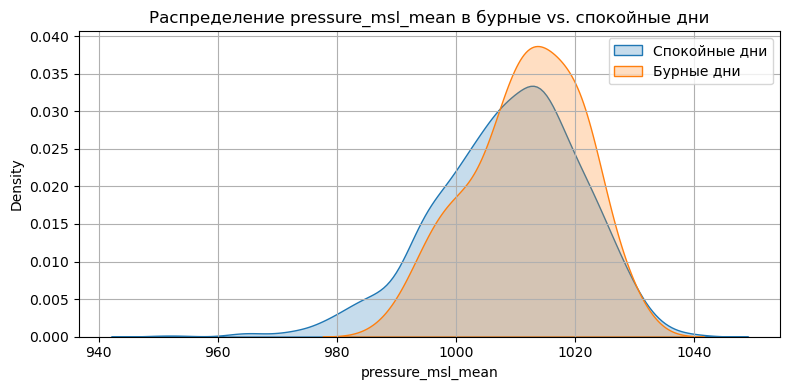

In [25]:
for col in cols_to_compare:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(data=quiet_days, x=col, label="Спокойные дни", fill=True)
    sns.kdeplot(data=storm_days, x=col, label="Бурные дни", fill=True)
    plt.title(f"Распределение {col} в бурные vs. спокойные дни")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## Основные наблюдения из EDA
#### 1. Корреляционная матрица

- Видно, что магнитные компоненты (dbz_nez, dbe_nez, dbn_nez и пр.) плохо коррелируют с погодными переменными — большинство коэффициентов в диапазоне от -0.2 до 0.2.

- Это ожидаемо, так как влияние солнечного ветра скорее нелинейное и краткосрочное, а не регулярное и линейное.

## Погодные параметры в "бурные" дни:
#### 2. Скорость ветра (wind_speed_10m_mean)

- Наблюдается небольшой сдвиг в сторону больших значений в бурные дни.

- Подтверждает гипотезу о слабом, но возможном усилении ветра при геомагнитной активности.

#### 3. Температура (temperature_2m_mean)

- Распределение в бурные дни немного сдвинуто вправо → в среднем чуть теплее.

- Возможно связано с временными аномалиями циркуляции воздуха.

#### 4. Осадки (precipitation_sum)

- Распределения почти одинаковы, но в бурные дни хвост чуть длиннее → иногда случаются более сильные осадки, но не систематически.

#### 5. Облачность (cloudcover_mean)

- В бурные дни облачность чаще выше.

- Может указывать на связанность с общей неустойчивостью атмосферы.

#### 6. Давление (pressure_msl_mean)

- Бурные дни смещены в сторону высокого давления.

- Это немного неожиданно — стоит изучить дополнительно (например, на локальных шкалах или по сезонам).

## Оценка суммарного влияния солнечного ветра на все признаки

Теперь попробуем оценить влияние солнечной активности (посредством мониторинга северного сияния) на все признаки вместе.

Сравним многомерные центры — сдвиг по совокупности признаков.

Мы можем использовать:

- PCA (Principal Component Analysis) — чтобы сжать многомерное пространство и визуализировать

- Euclidean distance между средними векторов признаков (mean vector)

- t-SNE или UMAP — для визуализации скрытых паттернов

#### PCA-анализ

In [26]:
df_combined.columns

Index(['temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean',
       'relative_humidity_2m_mean', 'pressure_msl_min', 'pressure_msl_max',
       'pressure_msl_mean', 'date', 'precipitation_sum', 'rain_sum',
       'snowfall_sum', 'precipitation_hours', 'cloudcover_mean',
       'wind_speed_10m_mean', 'wind_speed_10m_max', 'wind_gusts_10m_mean',
       'wind_gusts_10m_max', 'wind_direction_10m_dominant',
       'shortwave_radiation_sum', 'et0_fao_evapotranspiration',
       'apparent_temperature_max', 'apparent_temperature_min',
       'apparent_temperature_mean', 'weathercode', 'dbe_geo', 'dbe_nez',
       'dbn_geo', 'dbn_nez', 'dbz_geo', 'dbz_nez', 'decl', 'extent', 'glat',
       'glon', 'mcolat', 'mlt', 'npnt', 'sza', 'time_sc', 'geomagnetic_storm'],
      dtype='object')

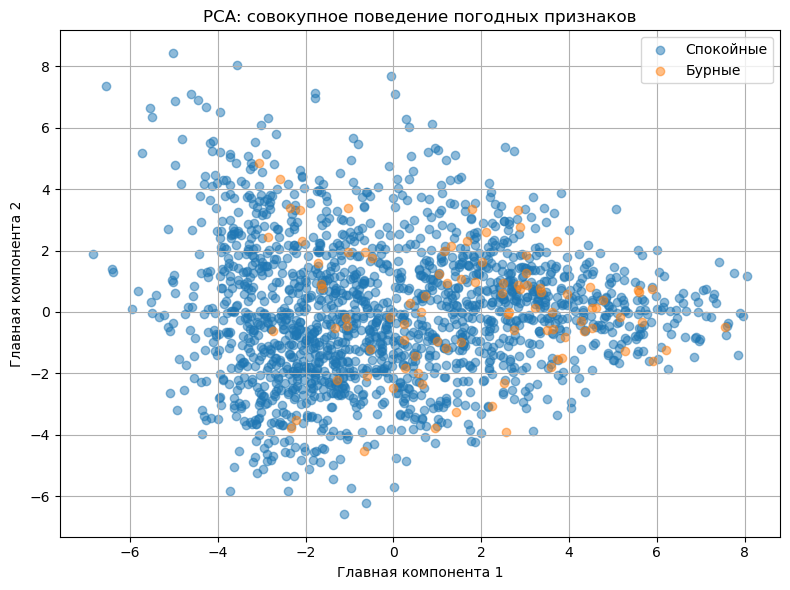

In [27]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Выбираем только числовые признаки о погоде и удаляем id/time etc.
exclude = ['date', 'id', 'glon', 'glat', 'time_sc', 'dbe_geo', 'dbe_nez',
       'dbn_geo', 'dbn_nez', 'dbz_geo', 'dbz_nez', 'decl', 'extent', 'glat'
           , 'mcolat', 'mlt', 'npnt', 'sza', 'geomagnetic_storm']
features = df_combined.drop(columns=exclude, errors="ignore").select_dtypes(include='number').columns

# Масштабируем
X = df_combined[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Добавляем метки классов
df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
df_pca["geomagnetic_storm"] = df_combined["geomagnetic_storm"].values

plt.figure(figsize=(8, 6))
for val, label in zip([0, 1], ["Спокойные", "Бурные"]):
    plt.scatter(df_pca[df_pca["geomagnetic_storm"] == val]["PC1"],
                df_pca[df_pca["geomagnetic_storm"] == val]["PC2"],
                label=label, alpha=0.5)

plt.title("PCA: совокупное поведение погодных признаков")
plt.xlabel("Главная компонента 1")
plt.ylabel("Главная компонента 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Что мы видим по PCA-графику**:

- Каждая точка — это один день, представленный по двум главным компонентам (сжатием всего многомерного пространства до 2D).

- Синие точки — спокойные дни

- Оранжевые точки — бурные дни

**Наблюдения:**

- Бурные дни не образуют чётко отдельного кластера, но...

- Они слегка смещены вправо и вниз, т.е. в пространстве признаков они отличаются.

- Заметен сдвиг центра — это и подтверждает Евклидово расстояние.

#### Расстояние между центрами двух групп

In [28]:
import numpy as np

center_bursts = X_scaled[df_combined["geomagnetic_storm"] == 1].mean(axis=0)
center_quiet = X_scaled[df_combined["geomagnetic_storm"] == 0].mean(axis=0)

distance = np.linalg.norm(center_bursts - center_quiet)
print(f"Евклидово расстояние между центрами бурных и спокойных дней: {distance:.4f}")


Евклидово расстояние между центрами бурных и спокойных дней: 1.9209


Это существенное значение, особенно учитывая, что данные были стандартизированы (скалированы StandardScaler-ом).

Это означает, что в среднем, поведение погодных признаков в бурные и спокойные дни различается, даже если по отдельности это было неочевидно.

## Интерпретация и вывод

- Геомагнитная активность влияет на атмосферу, но не через резкие скачки одного признака, а через совокупное поведение:

    - немного сильнее ветер,

    - немного выше температура,

    - чуть больше облачности или осадков и т.п.

- Эффект можно интерпретировать как многомерный атмосферный отклик.

Однако, невозможно сказать, что по исходным данным можно составить корректную модель предсказания влияния бурь, например, на ветер.

## Обработка выбросов

В классических задачах выбросы часто означают ошибки измерений, аномальные, но нерелевантные значения и т.д., но в погодных данных выбросы это нормально и зачастую именно они нас и интересуют

Например:

- день, когда скорость ветра резко возросла — может быть связан с бурей
- сильный скачок dbz — признак геомагнитной активности
- редкие высокие температуры или осадки — атмосферные аномалии

#### Вывод

Удалять выбросы в нашем случае было бы вредно.

- Мы анализируем влияние солнечного ветра на атмосферу.

- Нам интересны экстремальные реакции, и они часто и есть "выбросы".

- Мы строили анализ вокруг всплесков dbz — это и есть работа с т.н. выбросами.